<a href="https://colab.research.google.com/github/MatthewFried/Udemy/blob/master/Day1_Example1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Combined Cycle Power Plant 6 year Data**
We have several variables from our power plant.  Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP) of the plant. We will use exploratory data analysis (EDA) to develop an understanding of the data and then we will use a linear regerssion to test two potential models.

In [ ]:
import pandas as pd
import numpy as np

url = 'https://raw.githubusercontent.com/MatthewFried/Udemy/master/Day1/Day1_Data.csv'
df = pd.read_csv(url)
#columns_titles = ["EP","T",'V','AP','RH']
#df=df.reindex(columns=columns_titles)
df.head()



,T,V,AP,RH,EP
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


##**Basic Exploratory Data Analysis**

In [ ]:
df.describe()

,T,V,AP,RH,EP
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


In [ ]:
df.agg(['skew','kurt','sem'])

,T,V,AP,RH,EP
skew,-0.136393,0.198521,0.265445,-0.431839,0.306509
kurt,-1.037549,-1.444337,0.094237,-0.444526,-1.048521
sem,0.076189,0.129916,0.060714,0.149262,0.174480


In [ ]:
from scipy import stats as bob  
for col in df.columns:
  a = bob.hmean(df[col])
  b = bob.gmean(df[col])
  print(col + ':\t' + str(a) + '\t' + str(b))

T:	15.96072079292619	17.95937222625265
V:	51.38438409398994	52.82358194949038
AP:	1013.2243258257025	1013.2416934519393
RH:	69.87838140238046	71.69111290023949
EP:	453.73054434330743	454.04664374024685


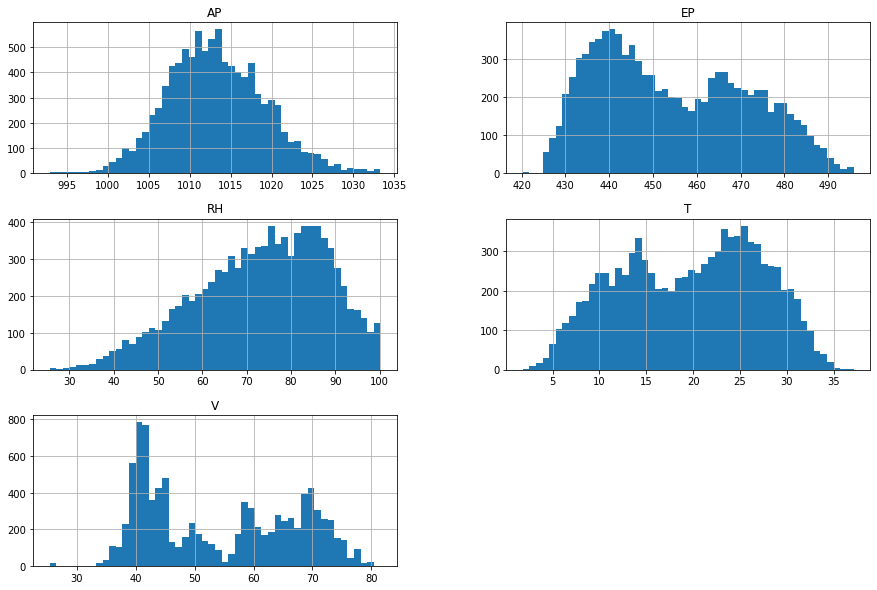

In [ ]:
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(15,10))
plt.show()

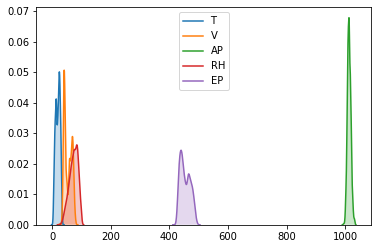

In [ ]:
#Kernal density estimates
import seaborn as sns

for col in df:
    sns.kdeplot(df[col], shade=True)


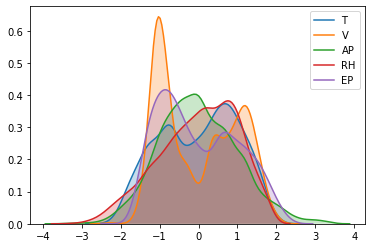

In [ ]:
#Normalized data
normalized_df=(df-df.mean())/df.std()
for col in df:
    sns.kdeplot(normalized_df[col], shade=True)

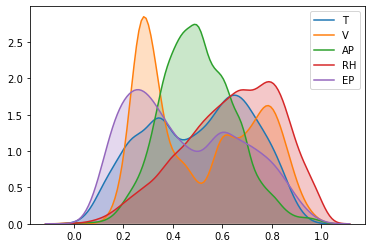

In [ ]:
#Min-max normalization
min_max_df=(df-df.min())/(df.max()-df.min())
for col in df:
    sns.kdeplot(min_max_df[col], shade=True)

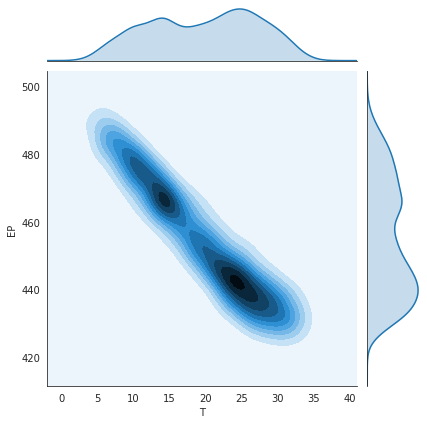

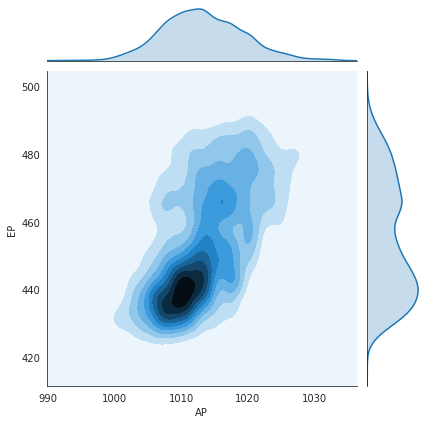

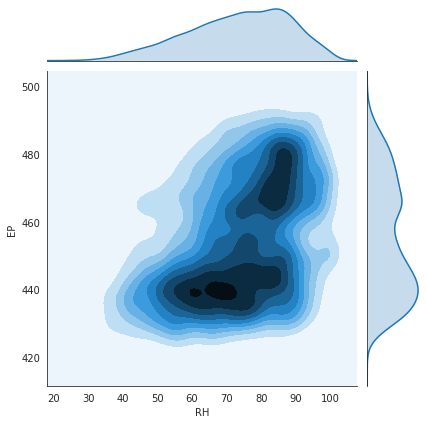

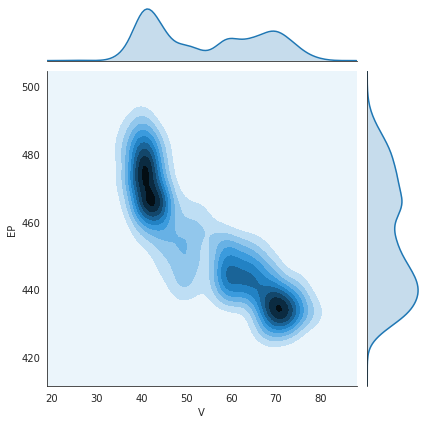

In [ ]:
with sns.axes_style('white'):
    sns.jointplot("T", "EP", df, kind='kde')
    sns.jointplot("AP", "EP", df, kind='kde')
    sns.jointplot("RH", "EP", df, kind='kde')
    sns.jointplot("V", "EP", df, kind='kde')

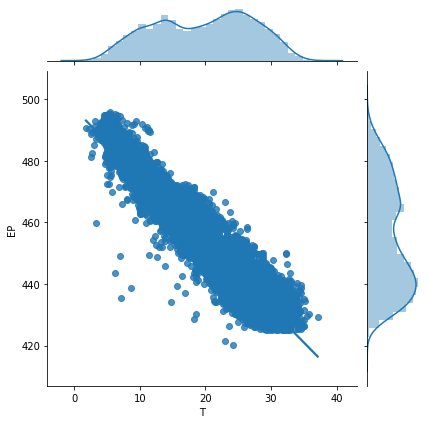

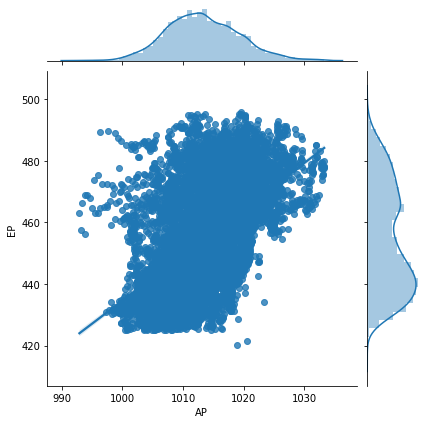

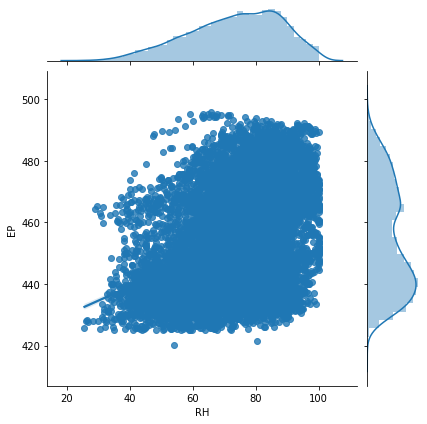

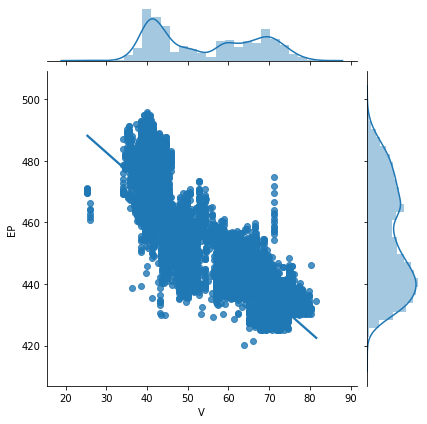

In [ ]:
def do_jointplot(df):
  a = sns.jointplot("T","EP",df,kind = "reg")
  b = sns.jointplot("AP","EP",df,kind = "reg")
  c= sns.jointplot("RH","EP",df,kind = "reg")
  d = sns.jointplot("V","EP",df,kind = "reg")

do_jointplot(df)

##Scaled Graphs
The above exploration was not very inforamtive as the data is somewhat large. While we note the lack of homoskedastic relationships among some variables, which would lead us to believe a regression may not be the best fit, below we scale the data so that we can "eyeball" it better and get a sense of what belongs and what doesn't

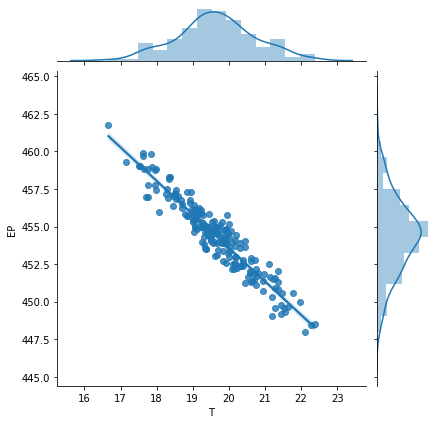

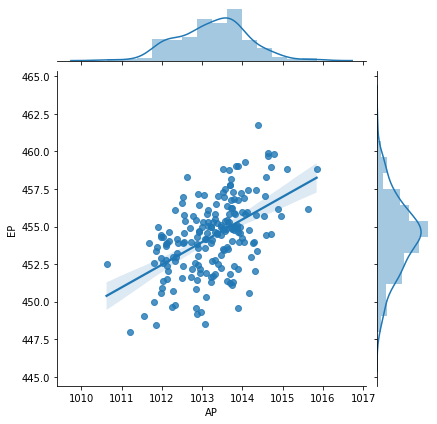

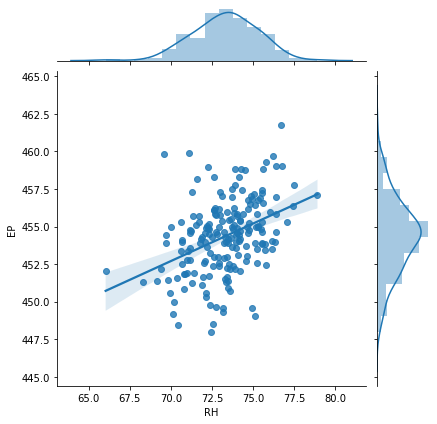

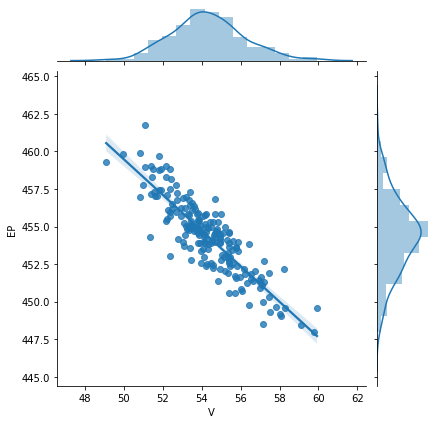

In [ ]:
#groups every N data points by thier mean to get a better general picture of the data
import pandas as pd

def scale_It(df,N):
  a = []
  for col in df.columns:
    a.append(df[col].groupby(df[col].index // N).mean())
  scaled_df = pd.DataFrame(a)
  return scaled_df.transpose()

x = scale_It(df,50)
do_jointplot(x)


##Correlation and Output
We see from the below that AP and RH have the highest correlation to EP, as such one model we will consider uses all explanatory variables while the second model will use only AP and RH. Also, above, the two variables can clearly be seen to have the most meaningful linear relationship, graphically, due to the KDE plots among others.

In [ ]:
#Correlation matrix
df.corr()

,T,V,AP,RH,EP
T,1.000000,0.844107,-0.507549,-0.542535,-0.948128
V,0.844107,1.000000,-0.413502,-0.312187,-0.869780
AP,-0.507549,-0.413502,1.000000,0.099574,0.518429
RH,-0.542535,-0.312187,0.099574,1.000000,0.389794
EP,-0.948128,-0.869780,0.518429,0.389794,1.000000


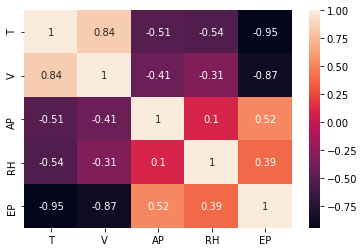

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

We are confirming that T and V have a very strong relationship to EP.  And we therefore will consider using it in our model.

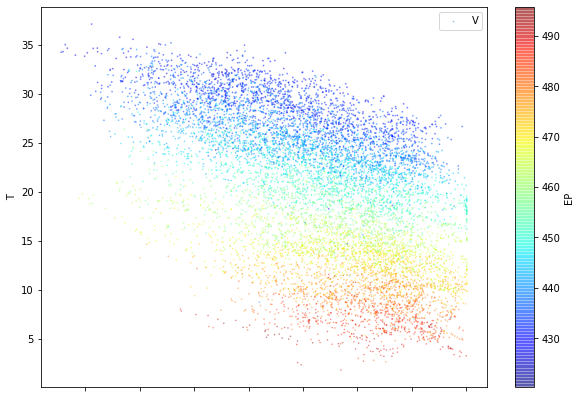

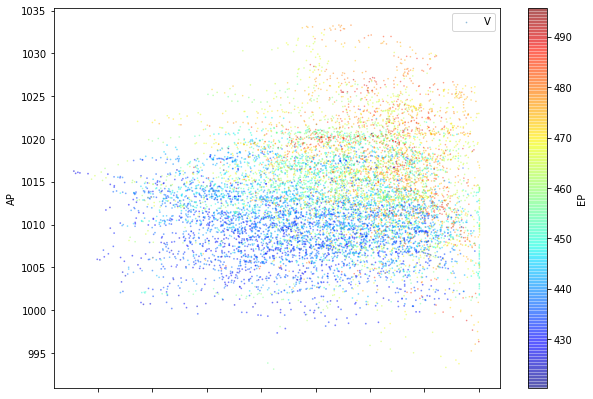

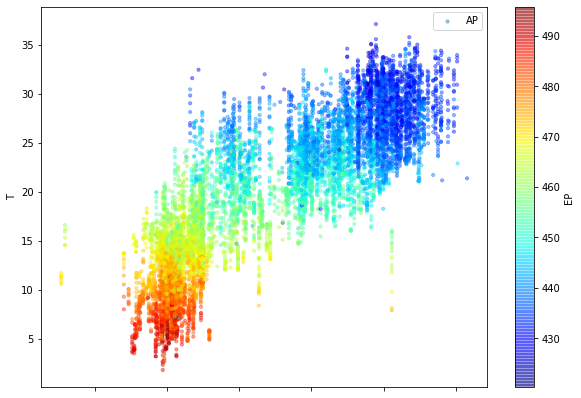

In [ ]:
df.plot(kind="scatter", x="RH", y="T", alpha=0.4,
    s=df["V"]/100, label="V", figsize=(10,7),
    c="EP", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

df.plot(kind="scatter", x="RH", y="AP", alpha=0.4,
    s=df["V"]/100, label="V", figsize=(10,7),
    c="EP", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

df.plot(kind="scatter", x="V", y="T", alpha=0.4,
    s=df["AP"]/100, label="AP", figsize=(10,7),
    c="EP", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

#**Model Testing**
Here we test the model, first against all explanatory variables and then against only the most correlated with the output variable

In [ ]:
#not a good enough model
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
#prepare the data, one with all explanatory, one with only AP and RH
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#first model
df_li = df.drop("T", axis =1)
df_li = df_li.drop('V', axis = 1)
df_li = df_li.drop('EP', axis = 1)

#second model
df_no_EP = df.drop("EP", axis=1)

#dependent variable to check
df_yes_EP = df["EP"].copy()

#set up pipeline
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

df_tr = num_pipeline.fit_transform(df_no_EP)
df_tr2 = num_pipeline.fit_transform(df_li)

num_attribs = list(df_no_EP)
num_attribs2 = list(df_li)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs)])

full_pipeline2 = ColumnTransformer([
        ("num", num_pipeline, num_attribs2)])

df_prepared_numpy = full_pipeline.fit_transform(df_no_EP)
df_prep2 = full_pipeline2.fit_transform(df_li)

df_prepared = pd.DataFrame(full_pipeline.fit_transform(df_no_EP))
df_prepared.columns = num_attribs
df_prepared.tail()




,T,V,AP,RH
9563,-0.402737,-0.363242,0.126450,1.211755
9564,-0.867037,-1.190331,1.753131,-0.447205
9565,1.565840,1.575811,-0.057099,-2.522618
9566,0.647976,1.191778,0.101191,-0.747901
9567,0.261507,0.646419,0.668677,-0.372545


In [ ]:
#Run Model 1
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(df_prepared_numpy,df_yes_EP)

some_data = df_no_EP.iloc[:4]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [467.26978996 444.0773659  483.56264263 450.55566825]


In [ ]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(df_yes_EP, lin_reg.predict(df_prepared_numpy))
lin_rmse = np.sqrt(lin_mse)
lin_rmse

4.557126016749485

In [ ]:
#Run model 2
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(df_prep2,df_yes_EP)

some_data2 = df_li.iloc[:4]
some_data_prepared2 = full_pipeline2.transform(some_data2)
print("Predictions:", lin_reg.predict(some_data_prepared2))

Predictions: [469.35974812 458.12381317 460.35351593 451.49201535]


In [ ]:
from sklearn.metrics import mean_squared_error

lin_mse2 = mean_squared_error(df_yes_EP, lin_reg.predict(df_prep2))
lin_rmse2 = np.sqrt(lin_mse2)
lin_rmse2

13.39146431623522

##**Cross Validation**
Here we check our model's reliability. We use cross-validation with k = 10. Other choices for k are possible, but general optimal results often coincide with k as 10, including our example. 
It is clear that the model with using all explanatory variables yeilds significantly better results.

In [ ]:
#Cross-Validation for Model 1
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
lin_reg.fit(df_prepared_numpy,df_yes_EP)

scores = cross_val_score(lin_reg, df_prepared_numpy, df_yes_EP,
                         scoring="neg_mean_squared_error", cv=10)
linreg_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

display_scores(linreg_rmse_scores)

Scores: [4.48646034 4.43453366 4.37543117 4.84802742 4.52260438 4.34530329
 4.42649875 4.80019038 4.78915655 4.53764453]
Mean: 4.556585045760783
Standard deviation: 0.17722254874432203


In [ ]:
#Cross-Validation for Model 2
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
lin_reg.fit(df_prep2,df_yes_EP)

scores2 = cross_val_score(lin_reg, df_prep2, df_yes_EP,
                         scoring="neg_mean_squared_error", cv=10)
linreg_rmse_scores2 = np.sqrt(-scores2)

def display_scores(scores2):
  print("Scores:", scores2)
  print("Mean:", scores2.mean())
  print("Standard deviation:", scores2.std())

display_scores(linreg_rmse_scores2)

Scores: [13.41207845 13.59869785 13.06509743 13.3762056  13.67596213 13.61405187
 12.80882788 13.87090535 13.26893945 13.25619356]
Mean: 13.394695957220662
Standard deviation: 0.2971763928920352


##Conclusions
Our conclusion is that the model that took into account all four explanatory variables is far better and less error prone than the second model. Checking both the RMSE and the K-fold crossover (with K = 10), we see that it produces significantly better results, in that the mean error is lower and the standard deviation is lower.

#__Problems__

1. Too many variable with bad names that keep cropping up
2. Too much spaghetti code
3. Should have used T and V for model, as is clear from EDA
4. Should have checked for missing data. No reason to use imputer, etc.
5. Should use more metrics to analyze model